In [ ]:
# https://notebook.community/angelmtenor/data-science-keras/machine_translation



In [1]:
# importing all the library 
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import time
import seaborn as sns
import sys
import random
import os
import requests
import glob
import helper
import numpy as np
import project_tests as tests
import collections
import re
import string
from pickle import load
from pickle import dump
from collections import Counter

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,plot_tree,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors, metrics,datasets,svm,linear_model, tree, ensemble
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.datasets import make_classification,load_iris,load_digits
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score,ParameterGrid,GridSearchCV,train_test_split
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer,HashingVectorizer, CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression,Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,Normalizer,StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import gmean

from numpy import mean,std
from matplotlib.colors import ListedColormap
from datetime import datetime

from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences




from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding

sns.set()
warnings.filterwarnings("ignore", category=DeprecationWarning) 
plt.style.use('fivethirtyeight')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import keras
# helper.info_gpu()
np.random.seed(9)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
importlib.reload(helper)

# helper.info_gpu()

<module 'helper' from 'C:\\Users\\Dhruv Jain\\Desktop\\Csc_641\\Project_Machine_Translation\\helper.py'>

In [3]:
# !wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
    
# import importlib
# importlib.reload(helper)
# !pip install wget



In [4]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8') as f:
        data = f.read()

    return data.split('\n')


with open('small_vocab_en', "r") as f:
    english_sentences = f.read().split('\n')
with open('small_vocab_fr', "r") as f:
    french_sentences = f.read().split('\n')

In [5]:
print("Number of sentences: {}\n".format(len(english_sentences)))
for i in range(5):
    print("sample {}:".format(i))
    print("{}  \n{} \n".format(english_sentences[i], french_sentences[i]))

Number of sentences: 137861

sample 0:
new jersey is sometimes quiet during autumn , and it is snowy in april .  
new jersey est parfois calme pendant l' automne , et il est neigeux en avril . 

sample 1:
the united states is usually chilly during july , and it is usually freezing in november .  
les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre . 

sample 2:
california is usually quiet during march , and it is usually hot in june .  
california est gÃ©nÃ©ralement calme en mars , et il est gÃ©nÃ©ralement chaud en juin . 

sample 3:
the united states is sometimes mild during june , and it is cold in september .  
les Ã©tats-unis est parfois lÃ©gÃ¨re en juin , et il fait froid en septembre . 

sample 4:
your least liked fruit is the grape , but my least liked is the apple .  
votre moins aimÃ© fruit est le raisin , mais mon moins aimÃ© est la pomme . 



In [6]:
import collections

words = dict()
words["English"] = [word for sentence in english_sentences for word in sentence.split()]
words["French"] = [word for sentence in french_sentences for word in sentence.split()]

for key, value in words.items():
    print("{}: {} words, {} unique words".format(key,
                                                 len(value), len(collections.Counter(value))))

English: 1823250 words, 227 unique words
French: 1961295 words, 355 unique words


In [71]:
# In [4]:
from keras.preprocessing.text import Tokenizer


def tokenize(x):
    """
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    tokens = tokenizer.texts_to_sequences(x)

    return tokens, tokenizer

In [83]:
# In [5]:

from tensorflow.keras.preprocessing.sequence import pad_sequences


def pad(x, length=None):
    """
    :param x: List of sequences.
    :param length: Length to pad the sequence to. If None, longest sequence length in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')

In [84]:
# In [6]:
def preprocess(x, y, length=None):
    """
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x, length)
    preprocess_y = pad(preprocess_y, length)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dims
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk


x, y, x_tk, y_tk = preprocess(english_sentences, french_sentences)
print('Data Preprocessed')

Data Preprocessed


In [86]:
# In [7]:
# Only the 10 last translations will be predicted
x_train, y_train = x[:-10], y[:-10]
x_test, y_test = x[-10:-1], y[-10:-1]  # last sentence removed
test_english_sentences, test_french_sentences = english_sentences[-10:], french_sentences[-10:]

In [87]:
# In [8]:
def logits_to_text(logits, tokenizer, show_pad=True):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>' if show_pad else ''

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [97]:
# In [9]:
from keras.models import Sequential
from keras.layers import GRU, Dense, TimeDistributed, LSTM, Bidirectional, RepeatVector
# from keras.layers.embeddings import Embedding
from keras.layers.core import Dropout
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers import Embedding
from tensorflow.keras import optimizers


def rnn_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build a model with embedding, encoder-decoder, and bidirectional RNN
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 0.01

    model = Sequential()

    vector_size = english_vocab_size // 10

    model.add(
        Embedding(
            english_vocab_size, vector_size, input_shape=input_shape[1:], mask_zero=False))
    model.add(Bidirectional(GRU(output_sequence_length)))
    model.add(Dense(128, activation='relu'))

    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(french_vocab_size, activation="softmax")))
    print(model.summary())

    model.compile(
        loss=sparse_categorical_crossentropy,
        optimizer=optimizers.Adam(learning_rate),
#         optimizer=keras.optimizers.adam(learning_rate),
        metrics=['accuracy'])

    return model


model = rnn_model(x_train.shape, y_train.shape[1], len(x_tk.word_index), len(y_tk.word_index))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 15, 19)            3781      
                                                                 
 bidirectional_10 (Bidirecti  (None, 42)               5292      
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               5504      
                                                                 
 repeat_vector_3 (RepeatVect  (None, 21, 128)          0         
 or)                                                             
                                                                 
 bidirectional_11 (Bidirecti  (None, 21, 256)          198144    
 onal)                                                           
                                                      

In [113]:
# In [10]:
print('Training...')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.fit(x_train, y_train, batch_size=10, epochs=5, verbose=0, \
                          validation_split=0.2, callbacks=callbacks)


Training...


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_6/embedding_6/embedding_lookup' defined at (most recent call last):
    File "C:\Users\Dhruv Jain\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Dhruv Jain\anaconda3\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Dhruv Jain\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Dhruv Jain\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Users\Dhruv Jain\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Dhruv Jain\AppData\Local\Temp\ipykernel_5488\1566322911.py", line 4, in <module>
      get_ipython().run_line_magic('time', 'history = model.fit(x_train, y_train, batch_size=10, epochs=5, verbose=0,                            validation_split=0.2, callbacks=callbacks)')
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2369, in run_line_magic
      result = fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1318, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 1, in <module>
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_6/embedding_6/embedding_lookup'
indices[6,0] = 199 is not in [0, 199)
	 [[{{node sequential_6/embedding_6/embedding_lookup}}]] [Op:__inference_train_function_101327]

In [114]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}\n".format(score[1]))

y = model.predict(x_test)

for idx, value in enumerate(y):
    print('Sample: {}'.format(test_english_sentences[idx]))
    print('Actual: {}'.format(test_french_sentences[idx]))
    print('Predicted: {}\n'.format(logits_to_text(value, y_tk, show_pad=False)))

Test Accuracy: 0.75

1/1 [==============================] - 1s 1s/step
Sample: california is never nice during october , and it is sometimes rainy in autumn .
Actual: californie est jamais agrÃ©able en octobre , et il est parfois pluvieux Ã  l' automne .
Predicted: californie est jamais calme en printemps et il est parfois parfois ã  l' automne       

Sample: our least liked fruit is the apple , but my least liked is the grape .
Actual: notre moins aimÃ© fruit est la pomme , mais mon moins aimÃ© est le raisin .
Predicted: votre fruits moins moins aimã© la la mais mon moins aimã© est est pãªche       

Sample: we plan to visit china in march .
Actual: nous prÃ©voyons une visite en chine en mars .
Predicted: nous prã©voyons de visiter californie ã©tats californie prochain prochain            

Sample: india is sometimes snowy during september , but it is never warm in winter .
Actual: l' inde est parfois enneigÃ©e en septembre , mais il est jamais chaud en hiver .
Predicted: l' inde est

In [4]:
english_sentences = load_data("small_vocab_en")
french_sentences =  load_data("small_vocab_fr")

In [18]:
# Open In Colab

# import the libraries
import collections
import re
import numpy as np
from keras import optimizers

from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.models import load_model
import os
import string
import requests
from keras.utils import pad_sequences
import unicodedata
from keras.callbacks import ModelCheckpoint
import regex

In [19]:
# convert to lowercase
for i in range(len(english_sentences)):
    english_sentences[i] = english_sentences[i].lower()
    
    french_sentences[i] = french_sentences[i].lower()

    english_sentences[i] = regex.sub(r'[^\x00-\x7f]', r'', english_sentences[i])
    french_sentences[i] = regex.sub(r'[^\x00-\x7f]', r'', french_sentences[i])

In [21]:

# empty lists
eng_l = []
frn_l = []

# populate the lists with sentence lengths
for i in english_sentences:
    eng_l.append(len(i))

for i in french_sentences:
    frn_l.append(len(i))

In [22]:
max(frn_l)


110

In [23]:

max(eng_l)

102

In [24]:
import pandas as pd
length_df = pd.DataFrame({'eng':eng_l, 'frn':frn_l})

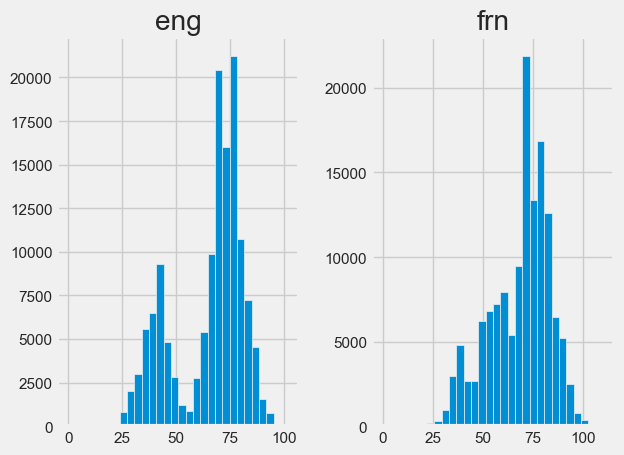

In [25]:
import matplotlib.pyplot as plt
length_df.hist(bins = 30)
plt.show()

In [26]:

print(max(eng_l), max(frn_l))

102 110


In [27]:

# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [28]:

# prepare english tokenizer
eng_tokenizer = tokenization(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 100
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 200


In [29]:
# prepare French tokenizer
frn_tokenizer = tokenization(french_sentences)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

frn_length = 111
print('French Vocabulary Size: %d' % frn_vocab_size)

French Vocabulary Size: 340


In [30]:
#encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [31]:
from sklearn.model_selection import train_test_split
frn_train, frn_test1, eng_train, eng_test1 = train_test_split(french_sentences,english_sentences, test_size=0.01, random_state = 12)

len(frn_train)

136482

In [32]:

len(frn_test1)



1379

In [33]:
len(eng_train)

136482

In [34]:
len(eng_test1)

1379

In [35]:

# prepare training data
frn_train = encode_sequences(frn_tokenizer, frn_length, frn_train)
eng_train = encode_sequences(eng_tokenizer, eng_length, eng_train)
     

In [36]:

# prepare validation data
frn_test = encode_sequences(frn_tokenizer, frn_length, frn_test1)
eng_test = encode_sequences(eng_tokenizer, eng_length, eng_test1)

In [55]:

# def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
#     model = Sequential()
#     model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
#     model.add(Bidirectional(LSTM(units, return_sequences=True)))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(units)))
#     model.add(RepeatVector(out_timesteps))
#     model.add(Bidirectional(LSTM(units, return_sequences=True)))
#     model.add(Dropout(0.2))
#     model.add(Dense(out_vocab, activation='softmax'))

#     return model


def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))
    return model


In [56]:

model = build_model(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [57]:

model.summary()
     

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 111, 512)          174080    
                                                                 
 bidirectional_5 (Bidirectio  (None, 1024)             4198400   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               205000    
                                                                 
Total params: 4,577,480
Trainable params: 4,577,480
Non-trainable params: 0
_________________________________________________________________


In [58]:
frn_train.shape

(136482, 111)

In [59]:
eng_train.shape

(136482, 100)

In [63]:

import numpy as np

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [5]:
for sample_i in range(3):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .
small_vocab_en Line 3:  california is usually quiet during march , and it is usually hot in june .
small_vocab_fr Line 3:  california est généralement calme en mars , et il est généralement chaud en juin .


In [6]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [7]:

def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # Create the tokeninzer
    t = Tokenizer()
    # Create dictionary mapping words (str) to their rank/index (int)
    t.fit_on_texts(x)
    # Use the tokenizer to tokenize the text
    text_sequences = t.texts_to_sequences(x)
    return text_sequences, t



# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


In [8]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    
    # If length equals None, set it to be the length of the longest sequence in x
    if length == None:
        length = len(max(x, key=len))
        
    # Use Keras's pad_sequences to pad the sequences with 0's
    padded_sequences = pad_sequences(sequences=x, maxlen=length, padding='post', value=0)
    
    return padded_sequences



# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


In [9]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


In [10]:

english_sentences_train, english_sentences_test, french_sentences_train, french_sentences_test =\
    train_test_split(english_sentences, french_sentences, test_size=0.2, random_state=42)

In [11]:
# Calculate the training set stats

english_train_words_counter = collections.Counter([word for sentence in english_sentences_train for word in sentence.split()])
french_train_words_counter = collections.Counter([word for sentence in french_sentences_train for word in sentence.split()])

print('{} English words in the training set.'.format(len([word for sentence in english_sentences_train for word in sentence.split()])))
print('{} unique English words in the training set.'.format(len(english_train_words_counter)))
print('10 Most common words in the English training dataset:')
print('"' + '" "'.join(list(zip(*english_train_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words in the training set.'.format(len([word for sentence in french_sentences_train for word in sentence.split()])))
print('{} unique French words in the training set.'.format(len(french_train_words_counter)))
print('10 Most common words in the French training dataset:')
print('"' + '" "'.join(list(zip(*french_train_words_counter.most_common(10)))[0]) + '"')

1458806 English words in the training set.
227 unique English words in the training set.
10 Most common words in the English training dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1568964 French words in the training set.
354 unique French words in the training set.
10 Most common words in the French training dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [12]:

# Calculate the test set stats

english_test_words_counter = collections.Counter([word for sentence in english_sentences_test for word in sentence.split()])
french_test_words_counter = collections.Counter([word for sentence in french_sentences_test for word in sentence.split()])

print('{} English words in the test set.'.format(len([word for sentence in english_sentences_test for word in sentence.split()])))
print('{} unique English words in the test set.'.format(len(english_test_words_counter)))
print('10 Most common words in the English test dataset:')
print('"' + '" "'.join(list(zip(*english_test_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words in the test set.'.format(len([word for sentence in french_sentences_test for word in sentence.split()])))
print('{} unique French words in the test set.'.format(len(french_test_words_counter)))
print('10 Most common words in the French test dataset:')
print('"' + '" "'.join(list(zip(*french_test_words_counter.most_common(10)))[0]) + '"')
     

364444 English words in the test set.
227 unique English words in the test set.
10 Most common words in the English test dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

392331 French words in the test set.
338 unique French words in the test set.
10 Most common words in the French test dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [13]:

# Preprocess the training split of the data

preproc_english_sentences_train, preproc_french_sentences_train, english_tokenizer_train, french_tokenizer_train =\
    preprocess(english_sentences_train, french_sentences_train)
    
max_english_sequence_length_train = preproc_english_sentences_train.shape[1]
max_french_sequence_length_train = preproc_french_sentences_train.shape[1]
english_vocab_size_train = len(english_tokenizer_train.word_index)
french_vocab_size_train = len(french_tokenizer_train.word_index)

print('Training Data Preprocessed')
print("Max English train dataset sentence length:", max_english_sequence_length_train)
print("Max French train dataset sentence length:", max_french_sequence_length_train)
print("English train dataset vocabulary size:", english_vocab_size_train)
print("French train dataset vocabulary size:", french_vocab_size_train)
     

Training Data Preprocessed
Max English train dataset sentence length: 15
Max French train dataset sentence length: 21
English train dataset vocabulary size: 199
French train dataset vocabulary size: 343


In [14]:

# Preprocess the test split of the data 

preproc_english_sentences_test, preproc_french_sentences_test, english_tokenizer_test, french_tokenizer_test =\
    preprocess(english_sentences_test, french_sentences_test)
    
max_english_sequence_length_test = preproc_english_sentences_test.shape[1]
max_french_sequence_length_test = preproc_french_sentences_test.shape[1]
english_vocab_size_test = len(english_tokenizer_test.word_index)
french_vocab_size_test = len(french_tokenizer_test.word_index)

print('Test Data Preprocessed')
print('Max English test dataset sentence length:', max_english_sequence_length_test)
print('Max French test dataset sentence length:', max_french_sequence_length_test)
print('English test datset vocab size:', english_vocab_size_test)
print('French test dataset vocab size', french_vocab_size_test)
print(preproc_french_sentences_test.shape)

Test Data Preprocessed
Max English test dataset sentence length: 15
Max French test dataset sentence length: 20
English test datset vocab size: 199
French test dataset vocab size 326
(27573, 20, 1)


In [90]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = ''

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [91]:

def encdec_model_train(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    # Build the encoder-decoder RNN model
    input_layer= Input(shape=input_shape[1:])
    encoder = Bidirectional(GRU(256, recurrent_dropout=0.2))(input_layer)
    repeat_vector = RepeatVector(output_sequence_length)(encoder)
    decoder = Bidirectional(GRU(256, return_sequences=True, recurrent_dropout=0.2))(repeat_vector)
    dense_layer = Dense(french_vocab_size, activation='relu')(decoder)
    output_layer = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(decoder)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    learning_rate = 0.01
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(lr=learning_rate),
                  metrics=['accuracy'])
    
    return model
     

In [92]:

es = EarlyStopping(monitor='val_loss', mode='min', patience = 5,  verbose=1)
     

In [93]:
# Reshape the input
# with tf.device("CPU"):
tmp_x = pad(preproc_english_sentences_train, max_french_sequence_length_train)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences_train.shape[-2], 1))

# Train the model
encoder_decoder_model_train = encdec_model_train(tmp_x.shape,
                                     max_french_sequence_length_train,
                                     english_vocab_size_train + 1,
                                     french_vocab_size_train + 1)
encoder_decoder_model_train.fit(tmp_x, preproc_french_sentences_train, callbacks=[es], batch_size=200, epochs=2, validation_split=0.2)

# # Print the prediction(s)
# print(logits_to_text(encoder_decoder_model_train.predict(tmp_x[:5])[0], french_tokenizer_train))

Epoch 1/2


C:\Users\Dhruv Jain\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


442/442 [==============================] - 460s 1s/step - loss: 1.6509 - accuracy: 0.5754 - val_loss: 1.3039 - val_accuracy: 0.6237
Epoch 2/2
442/442 [==============================] - 431s 975ms/step - loss: 1.2367 - accuracy: 0.6366 - val_loss: 1.1411 - val_accuracy: 0.6631


In [94]:
test_x = pad(preproc_english_sentences_test, max_french_sequence_length_test)
preproc_english_sentences_test.shape
preproc_french_sentences_train.shape

(110288, 21, 1)

In [95]:
test_x = pad(preproc_english_sentences_test, max_french_sequence_length_train)
test_x = test_x.reshape((-1, max_french_sequence_length_train, 1))
preproc_french_sentences_test = pad(preproc_french_sentences_test, max_french_sequence_length_train)  # Pad preproc_french_sentences_test
preproc_french_sentences_test = preproc_french_sentences_test.reshape((-1, max_french_sequence_length_train, 1))  # Reshape using max_french_sequence_length_train

print(test_x.shape)
print(preproc_french_sentences_train.shape)
print(preproc_french_sentences_test.shape)

# Evaluate the model
encoder_decoder_model_score = encoder_decoder_model_train.evaluate(test_x, preproc_french_sentences_test, verbose=0)

print("Encoder-decoder model accuracy on the unseen test data: {0:.2f}%".format(encoder_decoder_model_score[1]*100))


(27573, 21, 1)
(110288, 21, 1)
(27573, 21, 1)
Encoder-decoder model accuracy on the unseen test data: 58.04%


In [96]:

print(logits_to_text(encoder_decoder_model_train.predict(test_x[:4])[3], french_tokenizer_train))
print('\n')
print(french_sentences_test[:4][3])
     

1/1 [==============================] - 1s 819ms/step
nous détestons les oranges les les et les             


ils aiment les pommes , les oranges et les poires .


In [97]:
# Save the model to a file
encoder_decoder_model_train.save('my_model.h5')

In [98]:
from nltk.translate.bleu_score import corpus_bleu

# Generate predictions using the encoder-decoder model
predictions = encoder_decoder_model_train.predict(test_x[:10])

# Convert predictions from one-hot encoded vectors to integer indices
predicted_indices = np.argmax(predictions, axis=2)

# Convert integer indices to words
predicted_sentences = []
for indices in predicted_indices:
    predicted_sentence = ' '.join([french_tokenizer.word_index[i] for i in indices if i > 0])  # Exclude padding and start-of-sequence tokens
    predicted_sentences.append(predicted_sentence)

# Convert target sentences from one-hot encoded vectors to integer indices
target_indices = np.argmax(preproc_french_sentences_test, axis=2)

# Convert integer indices to words
target_sentences = []
for indices in target_indices:
    target_sentence = ' '.join([french_tokenizer[i] for i in indices if i > 0])  # Exclude padding and start-of-sequence tokens
    target_sentences.append(target_sentence)

# Calculate BLEU score
bleu_score = corpus_bleu([[sent] for sent in target_sentences], predicted_sentences)
print("BLEU score: {0:.4f}".format(bleu_score))

1/1 [==============================] - 0s 73ms/step


KeyError: 29